In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
from IPython.core.display import HTML 
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from xgboost import XGBClassifier

C:\Users\jcasa\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
C:\Users\jcasa\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
df_train = pd.read_csv('./prosperLoanData_train.csv')
df_oot = pd.read_csv('./prosperLoanData_oot.csv')
df_ri = pd.read_csv('./prosperLoanData_ri.csv')

C:\Users\jcasa\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
final_features = ['CurrentCreditLines', 'InquiriesLast6Months', 'CreditScoreRangeLower', 'ScorexChangeAtTimeOfListing',
                   'MonthlyLoanPayment', 'StatedMonthlyIncome', 'TotalTrades', "IsBorrowerHomeowner", "AmountDelinquent",
                   "IncomeRange", 'Occupation']

In [79]:
df_train.shape, df_oot.shape, df_ri.shape

((16987, 100), (13669, 100), (5662, 89))

In [4]:
def get_bucket_numfeature(df, feat_col, n_bins, input_slider=(0., 100.)):
    """Cuts a numeric feature in 'n_bins', balacing data in percentiles
    
    Args:
        df: Pandas DataFrame with the input data
        feat_col: Name of the column with the input feature
        obj_col: Name of the column with the target 
        n_bins: Number of cuts expected
        input_slider: Range considered for the bucketing
        
    Returns:
        List with the cuts corresponding to this feature
    """
    #get the numeric input from the dual slider
    perc_sliders = [v/100. for v in input_slider]
    var_lims = df[feat_col].quantile([perc_sliders[0], perc_sliders[1]]).values
    v_min, v_max = var_lims[0], var_lims[1]
    #filter the dataset using the slider input
    df_cut = df.loc[(df[feat_col] <= v_max) & (df[feat_col] >= v_min)][[feat_col]]
    cuts = df_cut[feat_col].quantile(np.linspace(perc_sliders[0], perc_sliders[1], n_bins + 1)).values.tolist()
    cuts = sorted(list(set(cuts)))
    return cuts

def format_dummy_col(feat_col, dummy_col):
    """Handles column names for dummy data
    
    Args:
        feat_col: Name of the column with the input feature
        dummy_col: String of the dummy column 
        
    Returns:
        Dummy column with better formatting
    """
    out = dummy_col.replace("(", "")\
                   .replace("]", "")\
                   .replace(".0", "")\
                   .replace(", ", "|")
    
    return feat_col + '_' + out
    
def apply_bucketing_num(df, feat_col, cuts):
    """Applies bucketing to numerical feature
    
    Args:
        df: Pandas Dataframe with the input data
        feat_col: Name of the column with the input feature
        cuts: Cuts that will be applied to the input data
        
    Returns:
        Pandas dataframe with dummy columns
    """
    cut_col = '{}_cut'.format(feat_col)
    if len(cuts) == 2:
        cuts = [cuts[0], np.mean(cuts), cuts[1]]
    df[cut_col] = pd.cut(df[feat_col], cuts, include_lowest=True, precision=0)
    if df[cut_col].isna().any():
        df[cut_col] = df[cut_col].cat.add_categories(["NA"])
        df[cut_col] = df[cut_col].fillna("NA")
        
    dummies_df = pd.get_dummies(df[cut_col], drop_first=True)
    dummies_df.columns = [format_dummy_col(feat_col, str(col)) for col in dummies_df.columns.values.tolist()]
    
    return dummies_df

def get_bucket_catfeature(df, feat_col, n_bins):
    """Cuts a categorical feature in 'n_bins', keeping categories with highest volume
    
    Args:
        df: Pandas DataFrame with the input data
        feat_col: Name of the column with the input feature
        n_bins: Number of cuts expected
        
    Returns:
        List with the cuts corresponding to this feature
    """
    cuts = df.groupby(feat_col)[feat_col].count().sort_values(ascending=False)[:int(n_bins)].index.values.tolist()
    
    return cuts

def apply_bucketing_cat(df, feat_col, cuts):
    """Applies bucketing to categorical feature
    
    Args:
        df: Pandas Dataframe with the input data
        feat_col: Name of the column with the input feature
        cuts: Cuts that will be applied to the input data
        
    Returns:
        Pandas dataframe with dummy columns
    """
    cut_col = '{}_cut'.format(feat_col)
    df[cut_col] = df[feat_col]
    df.loc[~df[cut_col].isin(cuts), cut_col] = 'Other'
    if df[cut_col].isna().any():
        df[cut_col] = df[cut_col].fillna("NA")
        
    dummies_df = pd.get_dummies(df[cut_col], prefix=feat_col, drop_first=True)
    
    return dummies_df

# A: 
def get_bucket_feature(df, feat_col, n_bins=6):
    """Trains bucketing in a feature, whether if it is numerical
    or categorical
    
    Args:
        df: Pandas Dataframe with the input data
        feat_col: Name of the column with the input feature
        n_bins: Cuts that will be applied to the input data
        
    Returns:
        List with the cuts learned from the data
    """
    if df[feat_col].dtypes == object:
        cuts = get_bucket_catfeature(df, feat_col, n_bins)
    else:
        cuts = get_bucket_numfeature(df, feat_col, n_bins)
    return cuts

def get_bucketing_allfeatures(df, features, n_bins=6):
    """Trains bucketing in all given features of a dataset
    
    Args:
        df: Pandas Dataframe with the input data
        features: Features which bucketing will be learnt
        n_bins: Cuts that will be applied to the input data
        
    Returns:
        Dict, containing all features and its corresponding
        bucketing. For example:
         {'feature1': cuts1,
          'feature2': cuts2}  
    """
    out_dict = {}
    for feature in features:
        cuts = get_bucket_feature(df, feature, n_bins)
        out_dict[feature] = cuts
    return out_dict

def apply_bucketing(df, feat_col, cuts):
    """Applies a bucketing schema
    
    Args:
        df: Pandas Dataframe with the input data
        feat_col: Name of the column with the input feature
        cuts: Cuts that will be applied to the input data
        
    Returns:
        Pandas DataFrame with columns dummy columns
    """
    if df[feat_col].dtypes == object:
        df_buck = apply_bucketing_cat(df, feat_col, cuts)
    else:
        df_buck = apply_bucketing_num(df, feat_col, cuts)
    return df_buck

In [5]:
dict_bucketing = get_bucketing_allfeatures(df_train, final_features, n_bins=4)
dict_bucketing

{'CurrentCreditLines': [0.0, 6.0, 9.0, 12.0, 40.0],
 'InquiriesLast6Months': [0.0, 1.0, 2.0, 27.0],
 'CreditScoreRangeLower': [600.0, 660.0, 700.0, 740.0, 880.0],
 'ScorexChangeAtTimeOfListing': [-209.0, -32.0, -3.0, 29.0, 257.0],
 'MonthlyLoanPayment': [0.0, 124.565, 180.74, 309.21, 2111.78],
 'StatedMonthlyIncome': [0.0, 3100.0, 4583.333333, 6666.666667, 483333.333333],
 'TotalTrades': [1.0, 14.0, 21.0, 30.0, 118.0],
 'IsBorrowerHomeowner': [0.0, 1.0],
 'AmountDelinquent': [0.0, 249209.0],
 'IncomeRange': ['$25,000-49,999',
  '$50,000-74,999',
  '$100,000+',
  '$75,000-99,999'],
 'Occupation': ['Other', 'Professional', 'Computer Programmer', 'Executive']}

In [6]:
len(final_features), len(dict_bucketing.keys())

(11, 11)

In [7]:
list_df_tr, list_df_ri = [], []
for feat in final_features:
    list_df_tr.append(apply_bucketing(df_train, feat, dict_bucketing[feat]))
    list_df_ri.append(apply_bucketing(df_ri, feat, dict_bucketing[feat]))

# Then 'vertically' combine them
df_tr_preproc = pd.concat(list_df_tr, axis=1)
df_ri_preproc = pd.concat(list_df_ri, axis=1)

# Capture the name of all buckets in our dataset
keep_cols_buck = df_tr_preproc.columns

In [8]:
len(list_df_tr), len(list_df_ri), df_tr_preproc.shape, df_ri_preproc.shape

(11, 11, (16987, 30), (5662, 31))

In [9]:
df_tr_preproc.shape, df_oot_preproc.shape

NameError: name 'df_oot_preproc' is not defined

In [11]:
# Capture the target in each subset
y_tr, y_ri = df_train['bad'], df_ri['bad']

In [12]:
def get_auc(y_true, y_pred):
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
    return metrics.auc(fpr, tpr)

In [13]:
glm_cols = ['CurrentCreditLines_6|9',
 'CurrentCreditLines_9|12',
 'CurrentCreditLines_12|40',
 'InquiriesLast6Months_1|2',
 'InquiriesLast6Months_2|27',
 'ScorexChangeAtTimeOfListing_-32|-3',
 'ScorexChangeAtTimeOfListing_-3|29',
 'ScorexChangeAtTimeOfListing_29|257',
 'ScorexChangeAtTimeOfListing_NA',
 'IsBorrowerHomeowner_0.5|1',
 'IncomeRange_$25,000-49,999',
 'IncomeRange_$50,000-74,999',
 'IncomeRange_$75,000-99,999',
 'IncomeRange_Other',
 'MonthlyLoanPayment_125|181',
 'MonthlyLoanPayment_181|309',
 'MonthlyLoanPayment_309|2112',
 'Occupation_Executive',
 'Occupation_Other',
 'Occupation_Professional',
 'TotalTrades_14|21',
 'TotalTrades_21|30',
 'TotalTrades_30|118',
 'StatedMonthlyIncome_3100|4583',
 'StatedMonthlyIncome_4583|6667',
 'StatedMonthlyIncome_6667|483333',
 'CreditScoreRangeLower_660|700',
 'CreditScoreRangeLower_700|740',
 'CreditScoreRangeLower_740|880',
 'AmountDelinquent_124604|249209']

In [14]:
#train first model
lr = LogisticRegression(solver='lbfgs', C=0.01)
lr.fit(df_tr_preproc[glm_cols], y_tr)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [15]:
df_tr_preproc[glm_cols].shape[0], len(y_tr)

(16987, 16987)

In [16]:
# Predict for all subsets
pred_tr = lr.predict_proba(df_tr_preproc[glm_cols])[:, 1]
pred_ri = lr.predict_proba(df_ri_preproc[glm_cols])[:, 1]

In [17]:
get_auc(y_tr, pred_tr), get_auc(y_ri, pred_ri)

(0.6838508477949512, 0.6807389359921687)

In [18]:
len(pred_ri), len(pred_tr)

(5662, 16987)

In [19]:
CutOff = pred_ri.mean()
CutOff

0.06264257872131554

In [20]:
pred_ri_df = pd.DataFrame(pred_ri, columns=['Prediccion'])

In [21]:
def convertPrediction(x):
    if(x <= CutOff):
        return 0
    else:
        return 1

pred_ri_df.Prediccion = pred_ri_df.Prediccion.apply(convertPrediction)

In [22]:
sum(pred_ri_df.Prediccion == 0), sum(pred_ri_df.Prediccion == 1)

(3170, 2492)

In [23]:
y_tr_new = y_tr.append(pred_ri_df.Prediccion, ignore_index=True)
df_tr_preproc_new = df_tr_preproc[glm_cols].append(df_ri_preproc[glm_cols], ignore_index = True)

In [24]:
df_tr_preproc_new.shape

(22649, 30)

In [25]:
y_tr_new.unique(), len(y_tr), len(y_tr_new)

(array([0, 1], dtype=int64), 16987, 22649)

In [26]:
lr = LogisticRegression(solver='lbfgs', C=0.01)
lr.fit(df_tr_preproc_new, y_tr_new)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Ahora hacemos las predicciones sobre el dataframe de test original

In [27]:
# Predict for all subsets
pred_oot = lr.predict_proba(df_tr_preproc_new)[:, 1]

In [28]:
get_auc(y_tr_new, pred_oot)

0.7907963543280936

In [29]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.figure(figsize=(12,10))
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1], "k--")
    plt.axis([0,1,0,1])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive rate")

In [30]:
logit_scores_proba = lr.predict_proba(df_tr_preproc_new)
logit_scores = logit_scores_proba[:,1]

AUC Score 0.7907963543280936


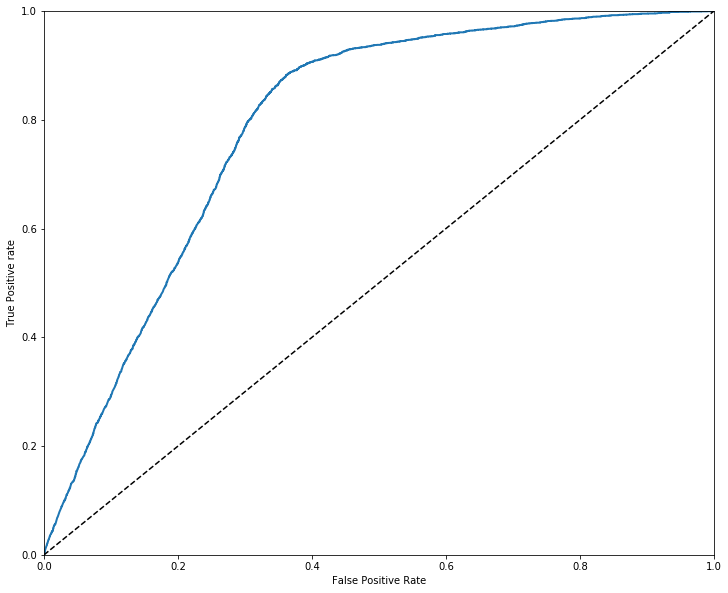

In [31]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr_logit, tpr_logit, thresh_logit = roc_curve(y_tr_new, logit_scores)
plot_roc_curve(fpr_logit,tpr_logit)
print("AUC Score {}".format(roc_auc_score(y_tr_new,logit_scores)))

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [33]:
X = df_train.drop("bad",axis=1)
y = df_train["bad"]

In [34]:
X.shape, y.shape

((16987, 99), (16987,))

In [35]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 42)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((12740, 99), (4247, 99), (12740,), (4247,))

In [36]:
X_train.columns

Index(['ListingKey', 'ListingNumber', 'ListingCreationDate', 'CreditGrade',
       'Term', 'LoanStatus', 'ClosedDate', 'BorrowerAPR', 'BorrowerRate',
       'LenderYield', 'EstimatedEffectiveYield', 'EstimatedLoss',
       'EstimatedReturn', 'ProsperRating (numeric)', 'ProsperRating (Alpha)',
       'ProsperScore', 'ListingCategory (numeric)', 'BorrowerState',
       'Occupation', 'EmploymentStatus', 'EmploymentStatusDuration',
       'IsBorrowerHomeowner', 'CurrentlyInGroup', 'GroupKey',
       'DateCreditPulled', 'CreditScoreRangeLower', 'CreditScoreRangeUpper',
       'FirstRecordedCreditLine', 'CurrentCreditLines', 'OpenCreditLines',
       'TotalCreditLinespast7years', 'OpenRevolvingAccounts',
       'OpenRevolvingMonthlyPayment', 'InquiriesLast6Months', 'TotalInquiries',
       'CurrentDelinquencies', 'AmountDelinquent', 'DelinquenciesLast7Years',
       'PublicRecordsLast10Years', 'PublicRecordsLast12Months',
       'RevolvingCreditBalance', 'BankcardUtilization',
       'Availa

In [37]:
logit = LogisticRegression(random_state=42, solver="saga", penalty="l1", class_weight="balanced", C=1.0, max_iter=500)

In [38]:
logit.fit(X_train, y_train)
logit_scores_proba = logit.predict_proba(X_train)
logit_scores = logit_scores_proba[:,1]

ValueError: could not convert string to float: 'Other'

In [39]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.figure(figsize=(12,10))
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1], "k--")
    plt.axis([0,1,0,1])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive rate")

In [40]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr_logit, tpr_logit, thresh_logit = roc_curve(y_train, logit_scores)
plot_roc_curve(fpr_logit,tpr_logit)
print("AUC Score {}".format(roc_auc_score(y_train,logit_scores)))

ValueError: Found input variables with inconsistent numbers of samples: [12740, 22649]

In [41]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

C:\Users\jcasa\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


ValueError: could not convert string to float: 'Other'

In [42]:
Y_pred_rlog = logreg.predict(X_val)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_val, y_val)))

NotFittedError: This LogisticRegression instance is not fitted yet

In [43]:
A partir de aquí lo que haremos

SyntaxError: invalid syntax (<ipython-input-43-944d17af6e10>, line 1)

In [33]:
sum(Y_pred_rlog == True)

1